Improved version of BaseModel #7
- TODO IN BASEMODEL 9 Log() transform is replaced with BoxCox transform for better distribution normalisation of more features
- Adding new features with feature engineering (For zero-value features + Combine some features due to their relations)
- Updated set of outliers from works of others

In [839]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.special import boxcox1p, inv_boxcox1p
from scipy.stats import boxcox_normmax

In [840]:
train = pd.read_csv("./dataset/train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [841]:
train.shape

(1460, 81)

# Missing Values

Sources on approaches with Missing Values: 
- https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard 
- https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook#Now-,-we-are-getting-started-with-the-process-of-modelling 
- https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook#EDA

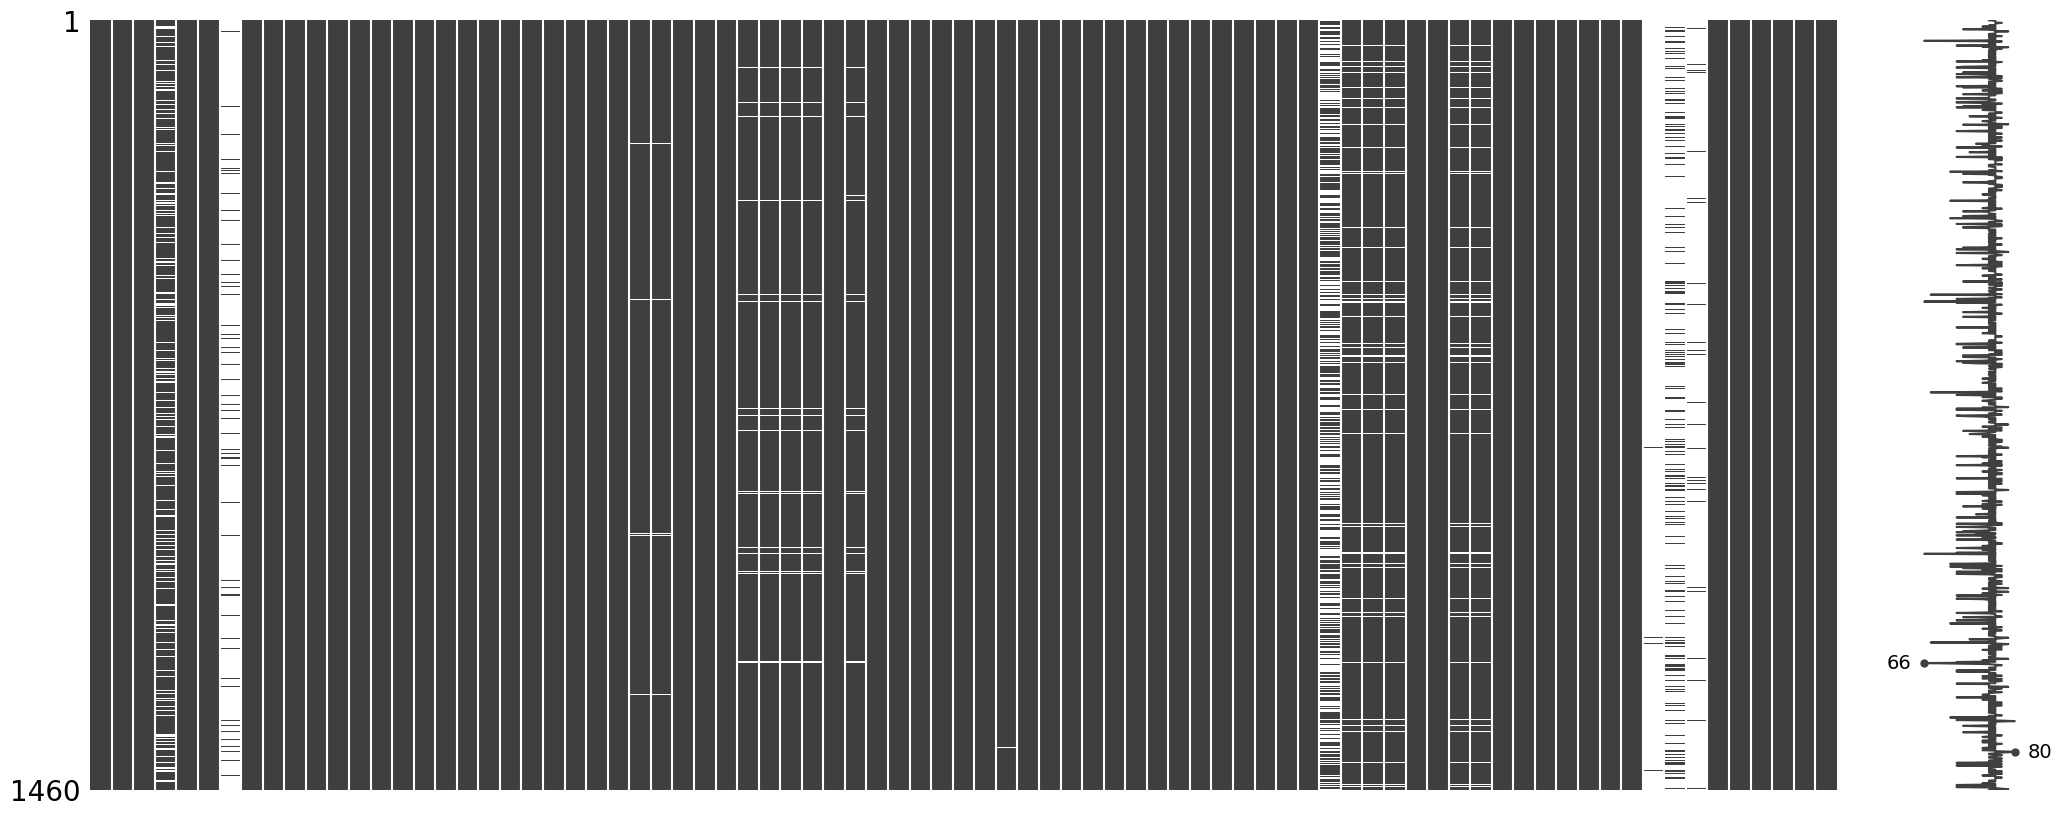

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274


In [842]:
import missingno as msno

msno.matrix(train);
plt.show()

all_data_na = (train.isnull().sum() / len(train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing Ratio" :all_data_na})
missing_data.head(5)

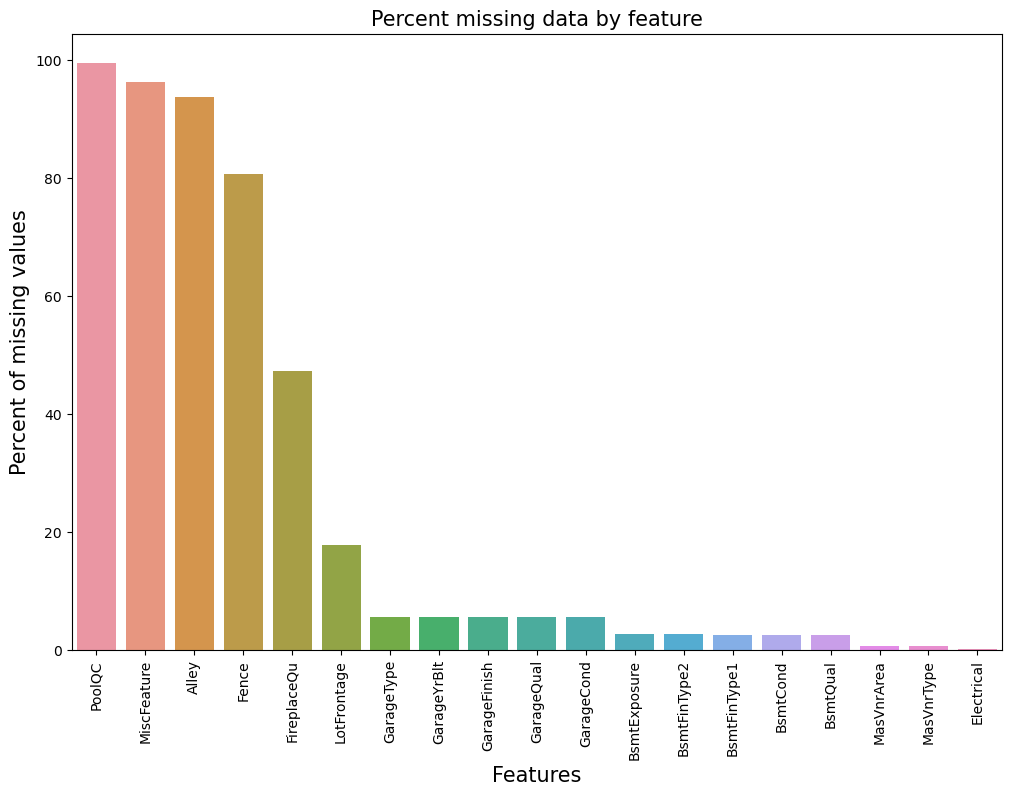

In [843]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na);
plt.xlabel("Features", fontsize=15)
plt.ylabel("Percent of missing values", fontsize=15)
plt.title("Percent missing data by feature", fontsize=15)
plt.show()

On the first glance it is clear that some features has too much data loss and you might want to simply remove them from dataset.

However, data exploration shows that some of them are actually trying to assign specific label with NaN and therefore no data is actualy lost, it is just stored incorrectly

Data Exploration:

- **PoolQC**: data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
- **MiscFeature**: data description says NA means "no misc feature"
- **Alley**: data description says NA means "no alley access"
- **Fence**: data description says NA means "no fence"
- **FireplaceQu**: data description says NA means "no fireplace"
- **LotFrontage**: can fill in missing values by the median LotFrontage of the neighborhood.
- **GarageType**, **GarageFinish**, **GarageQual** and **GarageCond**: Replacing missing data with "No_Garage"
- **GarageYrBlt**, **GarageArea** and **GarageCars**: Replacing missing data with 0 (Since No garage = no cars in such garage.)
- **BsmtFinSF1**, **BsmtFinSF2**, **BsmtUnfSF**, **TotalBsmtSF**, **BsmtFullBath** and **BsmtHalfBath**: Replacing missing data with 0 for having no basement
- **BsmtQual**, **BsmtCond**, **BsmtExposure**, **BsmtFinType1** and **BsmtFinType2**: For all these categorical basement-related features, replacing missing data with 0 as NaN means that there is no basement.
- **MasVnrArea** and **MasVnrType**: NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
- **MSZoning** (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with median ('RL')
- **Utilities**: For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely **drop** it.
- **Electrical**: It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
- **Exterior1st** and **Exterior2nd**: Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
- **SaleType**: Fill in again with mode ("WD")
- **Functional**: data description says NA means typical

In [844]:
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"):
	train[col] = train[col].fillna("No_" + col)

for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
	train[col] = train[col].fillna("No_Garage")
    
for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
	train[col] = train[col].fillna(0)
    
for col in ("BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF","TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"):
	train[col] = train[col].fillna(0)
    
for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
	train[col] = train[col].fillna("No_" + col)

train_modes_to_fill = {}	# Data For Test Dataset PreProcessing
for col in ("MSZoning", "Electrical", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"):
    train_modes_to_fill[col] = train[col].mode()[0]
    train[col] = train[col].fillna(train_modes_to_fill[col])
    
means_lot_frontage = train.groupby("Neighborhood")["LotFrontage"].median()
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(means_lot_frontage[x.name]))
    
train.drop(['Utilities'], axis=1, inplace=True)

train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["Functional"] = train["Functional"].fillna("Typ")


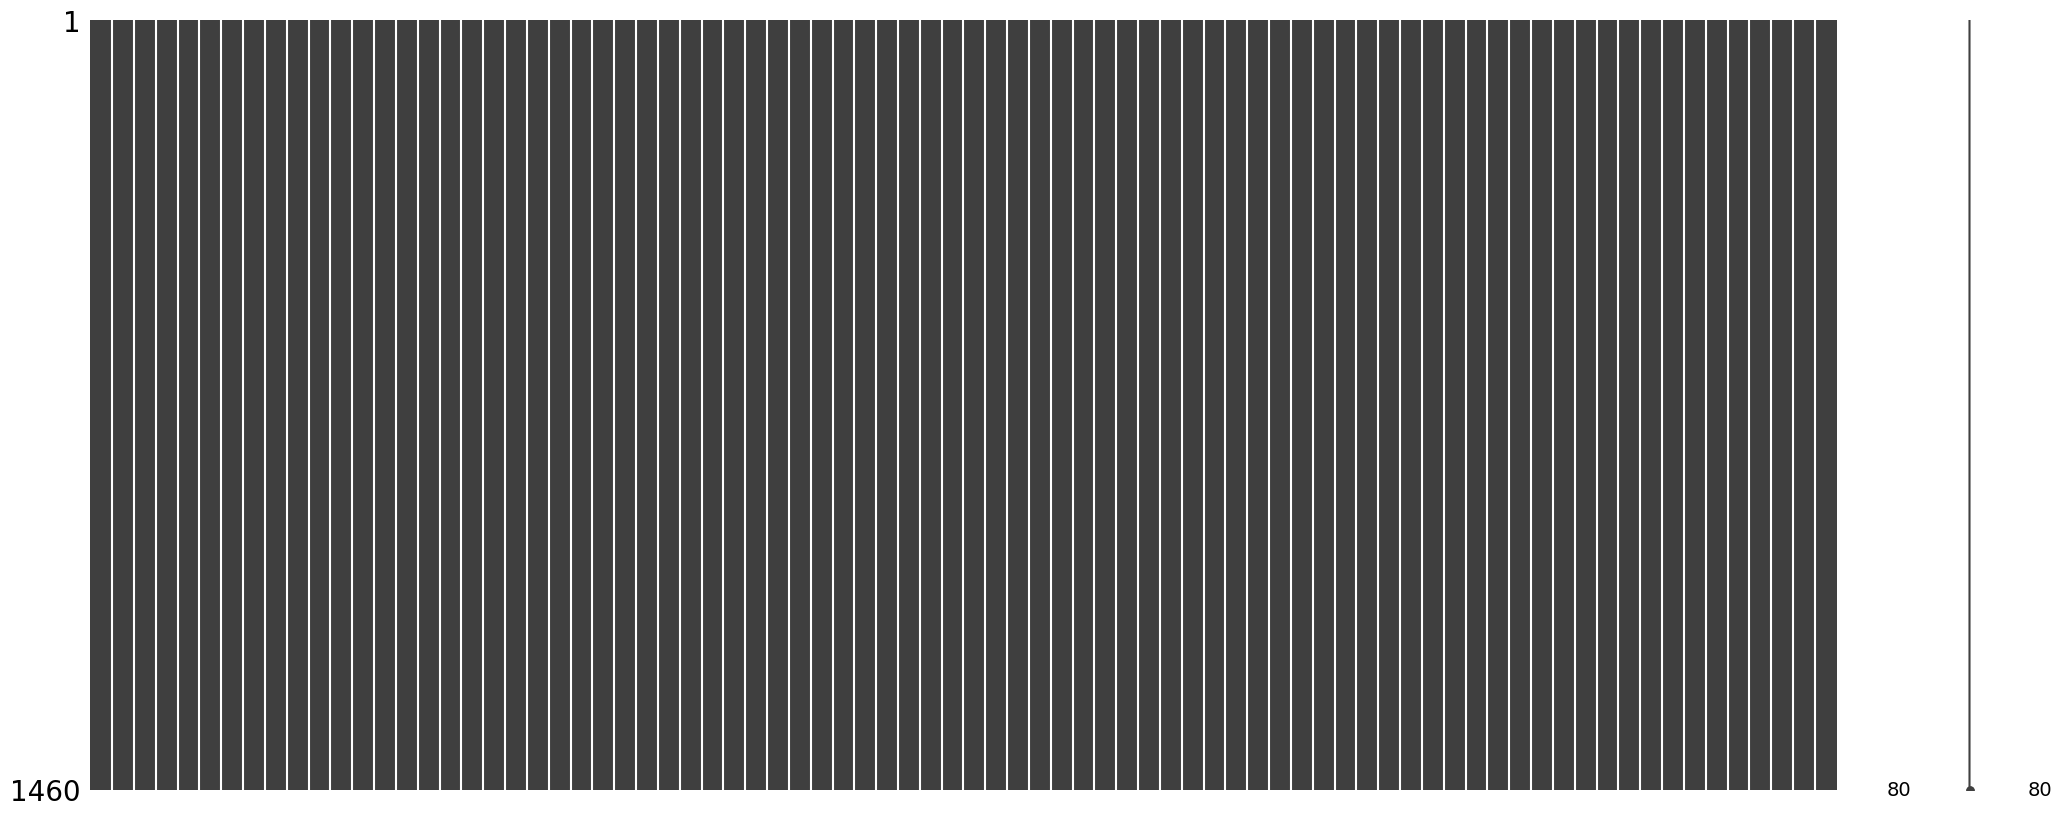

,Missing Ratio


In [845]:
msno.matrix(train);
plt.show()

all_data_na = (train.isnull().sum() / len(train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing Ratio" :all_data_na})
missing_data.head(5)

In [846]:
train.shape

(1460, 80)

# PreProcessing

Sources on EDA and PreProcessing:

- https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python 


In [847]:
train.drop(['Id'], axis=1, inplace=True)
train.shape

(1460, 79)

## 1. Remove Outliers

I will go through each feature and will store indexes of data points that are outside of my manual max_values for each of given features

In [848]:
outlier_ind = set()

outliers = {"LotFrontage": 300, "LotArea": 100000,
            "BsmtFinSF1": 5000, "MasVnrArea": 1300,
            "BsmtFinSF2": 1300, "TotalBsmtSF": 5000,
            "1stFlrSF": 4000, "GrLivArea": 5000,
            "OpenPorchSF": 470, "EnclosedPorch": 500,
            "SalePrice": 700000}

numerical_features = train.select_dtypes(exclude="object").columns
for feature_name, max_value in outliers.items():
    x = train[feature_name]
    x = x[x > max_value]
    outlier_ind.update(list(x.index))

outlier_ind

{197, 249, 297, 313, 322, 335, 495, 583, 691, 706, 934, 1169, 1182, 1298, 1328}

Adding Outliers from works of others (combining our efforts to get best results)

In [849]:
outliers = [30, 88, 462, 631, 1322]
outlier_ind.update(outliers)

In [850]:
train.drop(outlier_ind, inplace=True)

In [851]:
train.shape

(1440, 79)

And so, I just dropped 20 samples of 1460

I tried IQR methodology to drop all samples outside of the Q1 and Q3. But in this way I am removing hundreds of samples which only decreases the performance. 

I got information on dropping performance from personal experience and supported it with this discussion:
- https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/discussion/170472

Therefore, the outlier filtering must be done with a lot of causiousness. Perhaps, 15 outliers I found manually is enough for filtering


## 2. Numerical Categories

Found "funny" way of categorization with replacing strings with numbers. Don't believe it is going to work, but worth trying
- https://github.com/jvanelteren/housing/blob/master/2Feature%20Engineering.ipynb 

This section requires personalised approach for each feature

To decide what shall be done with each feature I will refer to its description

The main criteria to decide whther a feture shall be kept as a number or encoded as categorical variable is:
- Decide if hte neighbour values are highly correlated as number. 
    - For example, type "1" and type "2" could mean absolutely different type, while
1 bathroom and 2 bathrooms are describing the quantity of the same thing

Feature Description -> Decision:

- **MSSubClass** is a **type** of dwelling involved in the sale. -> Must be categorised
- **OverallQual** are **Rates** of the overall material and finish of the house. -> Could be a number
- **OverallCond** are **Rates** of the overall condition of the house -> Could be a number
- **BsmtFullBath** is **[number of]** Basement full bathrooms -> Could be a number (or could be combined)
- **BsmtHalfBath** is **[number of]** Basement half bathrooms -> Could be a number (or could be combined)
- **FullBath** is **[number of]** Full bathrooms above grade -> Could be a number (or could be combined)
- **HalfBath** is **[number of]** Half baths above grade -> Could be a number (or could be combined)
- **BedroomAbvGr** is **[number of]** Bedrooms above grade -> Could be a number
- **TotRmsAbvGrd** is **[number of]** Total rooms above grade -> Could be a number 
- **Fireplaces** is **[number of]** Number of fireplaces -> Could be a number 
- **GarageCars** is **Size** of garage in car capacity -> Could be a number 
- **MoSold** is **[number of]** Month Sold (MM) -> Could be a number or category
- **YrSold** is **[number of]** Year Sold (YYYY) -> Could be a number or category

From the list above we defined 1-3 features that could be categorised

In [852]:
num_to_category = ["MSSubClass", "MoSold", "YrSold"]
for ntc in num_to_category:
    train[ntc] = train[ntc].apply(str)
train[num_to_category[0]].info()

<class 'pandas.core.series.Series'>
Int64Index: 1440 entries, 0 to 1459
Series name: MSSubClass
Non-Null Count  Dtype 
--------------  ----- 
1440 non-null   object
dtypes: object(1)
memory usage: 22.5+ KB


## 3. Feature Engineering

sources:
- https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook#EDA 
- https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook#Final-Step-: 

the best one:
- https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition 

Here I create new features 

In [853]:
original_numeric_features = list(train.select_dtypes(exclude="object").columns)   # Save it before we add new features

In [854]:
train["BsmtFinType1_Unf"] = 1*(train["BsmtFinType1"] == "Unf")
train["HasWoodDeck"] = (train["WoodDeckSF"] == 0) * 1
train["HasOpenPorch"] = (train["OpenPorchSF"] == 0) * 1
train["HasEnclosedPorch"] = (train["EnclosedPorch"] == 0) * 1
train["Has3SsnPorch"] = (train["3SsnPorch"] == 0) * 1
train["HasScreenPorch"] = (train["ScreenPorch"] == 0) * 1
train["YearsSinceRemodel"] = train["YrSold"].astype(int) - train["YearRemodAdd"].astype(int)
train["Total_Home_Quality"] = train["OverallQual"] + train["OverallCond"]
train["TotalSF"] = train["TotalBsmtSF"] + train["1stFlrSF"] + train["2ndFlrSF"]
train["YrBltAndRemod"] = train["YearBuilt"] + train["YearRemodAdd"]

train["Total_sqr_footage"] = (train["BsmtFinSF1"] + train["BsmtFinSF2"] + train["1stFlrSF"] + train["2ndFlrSF"])
train["Total_Bathrooms"] = (train["FullBath"] + (0.5 * train["HalfBath"]) + train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]))
train["Total_porch_sf"] = (train["OpenPorchSF"] + train["3SsnPorch"] + train["EnclosedPorch"] + train["ScreenPorch"] + train["WoodDeckSF"])

train["haspool"] = train["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
train["has2ndfloor"] = train["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
train["hasgarage"] = train["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
train["hasbsmt"] = train["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
train["hasfireplace"] = train["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)

# Feature Engineering: Updated new features
train["YearRemodAdd_super_old"] = 1 * (train["YearRemodAdd"] <= 1950)

new_zero_features = ("MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "LowQualFinSF", "GarageYrBlt", "MiscVal")
for col in new_zero_features:
    train[col+"_zero"] = 1 * (train[col]  == 0)

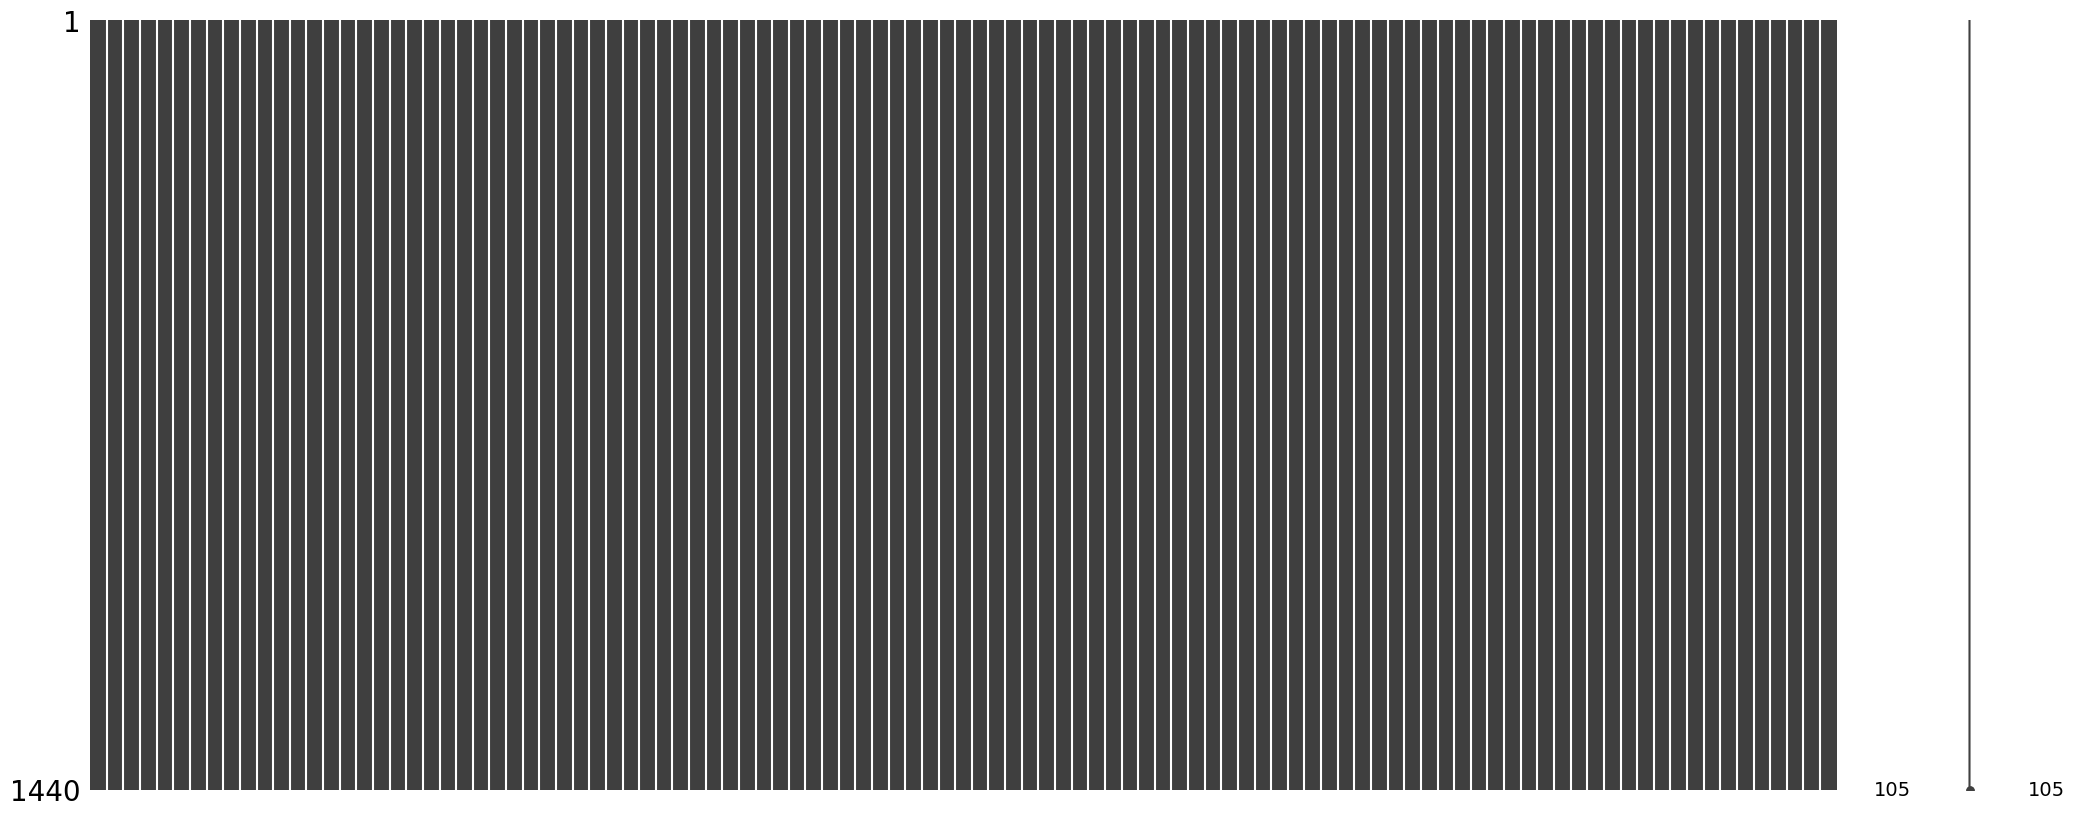

,Missing Ratio


In [855]:
msno.matrix(train);
plt.show()

all_data_na = (train.isnull().sum() / len(train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing Ratio" :all_data_na})
missing_data.head(5)

## 4. Distribution Normalization - Apply Boxcox() transform

Experiments showed that log() transform can improve some of features, while it can make worse distribution for others.

At the same time boxcox() transform doesn't make any features worse. Therefore, I will aply this transform to all numerical features

In [856]:
boxcox_num_feature_max = {}

original_numeric_features.remove("YearRemodAdd")    # Problematic feature. It gets to 1e+240 if you apply box-cox

for feature_name in original_numeric_features:
    boxcox_num_feature_max[feature_name] = boxcox_normmax(train[feature_name] + 1)
    train[feature_name] = boxcox1p(train[feature_name], boxcox_num_feature_max[feature_name])

c:\Users\nikit\anaconda3\envs\kaggle_house\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\nikit\anaconda3\envs\kaggle_house\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


# Category Encoding

Some people use Lable Encoding:
- https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
- https://github.com/jvanelteren/housing/blob/master/2Feature%20Engineering.ipynb 

The lable encoding shall be checked in next basemodel

Here I will perform OneHotEncoding

However, many works how INCORRECT APPROACH where they combine training and testing data together and apply preprocessing, including encoding, to the whole dataset. That is inappropriate, and can be reffered to issue called "data leak". The problems are: you cannot use testing data to get information for training (can't use test data for statistical values to replace NaN of training dataset) and cannot update number of categories from test data to be applied on whole dataset! In real case scenario only training dataset will be given and test is an actual application of the model to real world. Therefore, we must rely on training dataset and prepare pipeline for new-comming test dataset. Next works do that INCORRECTLY:
- https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook#Final-Step-:
- https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook#EDA
- https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard#Data-Processing
- https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python#4.-Missing-data 
- https://www.kaggle.com/code/apapiu/regularized-linear-models
- https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

That is one of the reasons top-leaders (Top 1%, etc) are doing that. The infer the test data and get better performance on testing set. But that is an incorrect approach which is impossible to replicate in the real world scenario

Therefore, here I use Encoder "trained" on training data and used to transform test and training data. The "ignor" parameter will ignore any new categories that are not present in training but appear in test set.


In [857]:
train_categorical = train.select_dtypes(include="object")
train_numerical = train.select_dtypes(exclude="object")

assert train_numerical.isna().sum().sum() == 0
assert train_categorical.isna().sum().sum() == 0
assert train_categorical.shape[1] + train_numerical.shape[1] == train.shape[1]

train_numerical.shape, train_categorical.shape, train.shape

((1440, 60), (1440, 45), (1440, 105))

In [858]:
uniq_df = {col:len(pd.unique(train_categorical[col])) for col in train_categorical.columns}
uniq_df = pd.Series(uniq_df).sort_values(ascending=False)
uniq_df[:8]

Neighborhood    25
Exterior2nd     16
MSSubClass      15
Exterior1st     15
MoSold          12
Condition1       9
SaleType         9
HouseStyle       8
dtype: int64

When there are lots of categories - One Hot Encoding might not be the best case

I will try:
- Dropping them -> Got worse results
- Applying label encoding to them

In [859]:
bad_encoding_features = uniq_df[uniq_df > 10]
bad_encoding_features

# Label Encoding
label_categories = train_categorical[bad_encoding_features.index]
train_categorical.drop(bad_encoding_features.index, axis=1, inplace=True);
label_categories.head()

,Neighborhood,Exterior2nd,MSSubClass,Exterior1st,MoSold
0,CollgCr,VinylSd,60,VinylSd,2
1,Veenker,MetalSd,20,MetalSd,5
2,CollgCr,VinylSd,60,VinylSd,9
3,Crawfor,Wd Shng,70,Wd Sdng,2
4,NoRidge,VinylSd,60,VinylSd,12


In [860]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
oe.fit(label_categories)

label_encoded = pd.DataFrame(oe.transform(label_categories), 
                                  columns=list(oe.get_feature_names_out()),
                                  index=train_categorical.index, 
                                  dtype=int)
label_encoded.head()

ValueError: The used value for unknown_value 0 is one of the values already used for encoding the seen categories.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(train_categorical)

ohe_categories = pd.DataFrame(ohe.transform(train_categorical).toarray(), 
                                  columns=list(ohe.get_feature_names_out()),
                                  index=train_categorical.index, 
                                  dtype=int)
ohe_categories.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No_Alley,Alley_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
encoded_categorical = pd.concat([ohe_categories, label_encoded], axis=1)
train = pd.concat([train_numerical, encoded_categorical], axis=1)
train.shape

(1440, 275)

In [ ]:
train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Neighborhood,Exterior2nd,MSSubClass,Exterior1st,MoSold
0,27.984138,25.596827,5.371388,2.969544,1.227833e+52,2003,20.742574,187.422818,0.0,30.411990,...,0,0,0,1,0,5,13,9,12,4
1,32.732085,26.389703,4.698377,4.123194,9.863929e+51,1976,0.000000,240.091021,0.0,44.853805,...,0,0,0,1,0,24,8,4,8,7
2,28.955087,27.403995,5.371388,2.969544,1.208203e+52,2002,18.912331,141.064416,0.0,57.909560,...,0,0,0,1,0,5,13,9,12,11
3,26.339098,26.356854,5.371388,2.969544,5.947678e+51,1970,0.000000,75.950004,0.0,66.014454,...,0,0,0,0,0,6,15,10,13,4
4,33.956964,28.981704,6.028013,2.969544,1.198498e+52,2000,27.356336,177.034852,0.0,62.282473,...,0,0,0,1,0,15,13,9,12,3


# Data Separation

In [ ]:
y = train["SalePrice"]
X = train.drop(["SalePrice"], axis=1)

# Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X = pd.DataFrame(scaler.transform(X))

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
0,-0.189973,-0.166168,0.679707,-0.500591,1.125774,0.878641,1.023098,0.717083,-0.347161,-0.940272,...,-0.059028,-0.30288,-0.045691,0.391053,-0.268750,-0.052778,-0.09167,-0.118678,0.466095,-0.306961
1,0.544591,0.099585,-0.043937,2.087460,0.046338,-0.428929,-0.744266,1.233698,-0.347161,-0.508328,...,-0.059028,-0.30288,-0.045691,0.391053,-0.268750,-0.052778,-0.09167,-0.118678,0.466095,-0.306961
2,-0.039755,0.439551,0.679707,-0.500591,1.038009,0.830213,0.867153,0.262360,-0.347161,-0.117841,...,-0.059028,-0.30288,-0.045691,0.391053,-0.268750,-0.052778,-0.09167,-0.118678,0.466095,-0.306961
3,-0.444480,0.088575,0.679707,-0.500591,-1.704547,-0.719500,-0.744266,-0.376339,-0.347161,0.124571,...,-0.059028,-0.30288,-0.045691,0.391053,3.720935,-0.052778,-0.09167,-0.118678,-2.145487,-0.306961
4,0.734094,0.968360,1.385733,-0.500591,0.994622,0.733356,1.586622,0.615189,-0.347161,0.012950,...,-0.059028,-0.30288,-0.045691,0.391053,-0.268750,-0.052778,-0.09167,-0.118678,0.466095,-0.306961


In [ ]:
y

0       8.183684
1       8.125233
2       8.212749
3       8.014255
4       8.259327
          ...   
1455    8.109766
1456    8.186690
1457    8.285729
1458    8.020751
1459    8.036727
Name: SalePrice, Length: 1440, dtype: float64

In [ ]:
X.shape, y.shape

((1440, 269), (1440,))

# Modeling

Inspiration:
- https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook#Models 
- https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook#Now-,-we-are-getting-started-with-the-process-of-modelling 

In [ ]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from datetime import datetime
import numpy as np

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X, y=y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=int(1e5), alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=int(1e5), alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=3000, 
    learning_rate=0.05,
    max_depth=4, 
    max_features='sqrt', 
    min_samples_leaf=15, 
    min_samples_split=10, 
    loss='huber', 
    random_state =42
) 

In [ ]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [ ]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,    # reg:squarederror
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

TEST score on CV
Kernel Ridge score: 0.0544 (0.0097)
 2023-04-12 14:39:29.290738
LASSO: 0.0519 (0.0095)
 2023-04-12 14:39:39.883890
elastic net: 0.0520 (0.0095)
 2023-04-12 14:40:17.107332
SVR: 0.0547 (0.0078)
 2023-04-12 14:40:22.877463
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_

In [ ]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[14:45:51] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:55] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:00] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:06] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:12] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fe

In [ ]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [ ]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.023300188399391374


# Submission

Now I repeat the same PreProcessing process as I did for Training Set

**But**, I must **only** use statistical data and scalers trained on training set!

In [ ]:
test = pd.read_csv("./dataset/test.csv")
test.drop(['Id'], axis=1, inplace=True)
        
# Transforming fake numerical features to categorical features
for ntc in num_to_category:
    test[ntc] = test[ntc].apply(str)
    
# Missing Values
all_data_na = (test.isnull().sum() / len(test)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing Ratio" :all_data_na})
missing_data.head(5)

,Missing Ratio
PoolQC,99.794380
MiscFeature,96.504455
Alley,92.666210
Fence,80.123372
FireplaceQu,50.034270


In [ ]:
# Missing Values
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"):
    test[col] = test[col].fillna("No_" + col)

for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
    test[col] = test[col].fillna("No_Garage")
   
for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
    test[col] = test[col].fillna(0)
   
for col in ("BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF","TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"):
    test[col] = test[col].fillna(0)
   
for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
    test[col] = test[col].fillna("No_" + col)

for col in ("MSZoning", "Electrical", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"):
    test[col] = test[col].fillna(train_modes_to_fill[col])
   
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(means_lot_frontage[x.name]))
test.drop(['Utilities'], axis=1, inplace=True)

test["MasVnrArea"] = test["MasVnrArea"].fillna(0)
test["MasVnrType"] = test["MasVnrType"].fillna("None")
test["Functional"] = test["Functional"].fillna("Typ")

all_data_na = (test.isnull().sum() / len(test)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing Ratio" :all_data_na})
missing_data.head(5)

,Missing Ratio


In [ ]:
# Feature Engineering
test["BsmtFinType1_Unf"] = 1*(test["BsmtFinType1"] == "Unf")
test["HasWoodDeck"] = (test["WoodDeckSF"] == 0) * 1
test["HasOpenPorch"] = (test["OpenPorchSF"] == 0) * 1
test["HasEnclosedPorch"] = (test["EnclosedPorch"] == 0) * 1
test["Has3SsnPorch"] = (test["3SsnPorch"] == 0) * 1
test["HasScreenPorch"] = (test["ScreenPorch"] == 0) * 1
test["YearsSinceRemodel"] = test["YrSold"].astype(int) - test["YearRemodAdd"].astype(int)
test["Total_Home_Quality"] = test["OverallQual"] + test["OverallCond"]
test["TotalSF"] = test["TotalBsmtSF"] + test["1stFlrSF"] + test["2ndFlrSF"]
test["YrBltAndRemod"] = test["YearBuilt"] + test["YearRemodAdd"]

test["Total_sqr_footage"] = (test["BsmtFinSF1"] + test["BsmtFinSF2"] + test["1stFlrSF"] + test["2ndFlrSF"])
test["Total_Bathrooms"] = (test["FullBath"] + (0.5 * test["HalfBath"]) + test["BsmtFullBath"] + (0.5 * test["BsmtHalfBath"]))
test["Total_porch_sf"] = (test["OpenPorchSF"] + test["3SsnPorch"] + test["EnclosedPorch"] + test["ScreenPorch"] + test["WoodDeckSF"])

test["haspool"] = test["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
test["has2ndfloor"] = test["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
test["hasgarage"] = test["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
test["hasbsmt"] = test["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
test["hasfireplace"] = test["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)

# Feature Engineering: Updated new features
test["YearRemodAdd_super_old"] = 1 * (test["YearRemodAdd"] <= 1950)

new_zero_features = ("MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "LowQualFinSF", "GarageYrBlt", "MiscVal")
for col in new_zero_features:
    test[col+"_zero"] = 1 * (test[col]  == 0)

In [ ]:
# Distribution Normalisation
original_numeric_features.remove("SalePrice")   # Test set doesn't have target numerical variable
for feature_name in original_numeric_features:
    test[feature_name] = boxcox1p(test[feature_name], boxcox_num_feature_max[feature_name])

In [ ]:
# Encoding Categorical features
test_categorical = test.select_dtypes(include="object")
test_numerical = test.select_dtypes(exclude="object")

# Label Encoding
label_categories = test_categorical[bad_encoding_features.index]
test_categorical.drop(bad_encoding_features.index, axis=1, inplace=True);
label_encoded_test = pd.DataFrame(oe.transform(label_categories), 
                            columns=list(oe.get_feature_names_out()),
                            index=test_categorical.index, 
                            dtype=int)
label_encoded_test.head()

In [ ]:
ohe_categories = pd.DataFrame(ohe.transform(test_categorical).toarray(), 
                                  columns=list(ohe.get_feature_names_out()),
                                  index=test_categorical.index, 
                                  dtype=int)
ohe_categories.head()


encoded_categorical = pd.concat([ohe_categories, label_encoded_test], axis=1)
test = pd.concat([test_numerical, encoded_categorical], axis=1)
test.shape

(1459, 269)

In [ ]:
# Scaling
X_test = pd.DataFrame(scaler.transform(test))
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
0,0.544591,0.510629,-0.788275,0.419242,-0.463806,-1.155356,-0.744266,0.223149,2.103716,-0.548734,...,-0.059028,-0.30288,-0.045691,0.391053,-0.26875,-0.052778,-0.09167,-0.118678,0.466095,-0.306961
1,0.592197,0.969481,-0.043937,0.419242,-0.558951,-1.300642,0.575818,1.132406,-0.347161,-0.185855,...,-0.059028,-0.30288,-0.045691,0.391053,-0.26875,-0.052778,-0.09167,-0.118678,0.466095,-0.306961
2,0.255551,0.898646,-0.788275,-0.500591,0.866414,0.636499,-0.744266,0.883028,-0.347161,-0.989520,...,-0.059028,-0.30288,-0.045691,0.391053,-0.26875,-0.052778,-0.09167,-0.118678,0.466095,-0.306961
3,0.448902,0.181371,-0.043937,0.419242,0.908827,0.636499,-0.201612,0.507227,-0.347161,-0.397206,...,-0.059028,-0.30288,-0.045691,0.391053,-0.26875,-0.052778,-0.09167,-0.118678,0.466095,-0.306961
4,-1.356317,-1.188382,1.385733,-0.500591,0.659108,0.345928,-0.744266,-0.255228,-0.347161,1.030045,...,-0.059028,-0.30288,-0.045691,0.391053,-0.26875,-0.052778,-0.09167,-0.118678,0.466095,-0.306961


In [ ]:
# Predicting Test Set
y_hat = inv_boxcox1p(blend_models_predict(X_test), boxcox_num_feature_max["SalePrice"])
y_hat

array([124654.71991111, 163308.89780728, 186077.09342449, ...,
       174882.28750362, 115983.44894514, 228516.11185557])

In [ ]:
submission = pd.read_csv("./dataset/sample_submission.csv")
my_submission = pd.DataFrame({'Id': submission.Id, 'SalePrice': y_hat})
my_submission.head()

,Id,SalePrice
0,1461,124654.719911
1,1462,163308.897807
2,1463,186077.093424
3,1464,197320.949124
4,1465,187455.452060


In [ ]:
my_submission.to_csv('submission_BL8.csv', index=False)

Final Score: 0.12188